# ThroughPut Architecture Testing Notebook

This notebook demonstrates and tests the three architecture implementations from the generators folder:
1. Semantic Router V1
2. Agent V1
3. Agent V2

We'll import the necessary components, set up the required services, and run test prompts for each architecture.

In [1]:
import sys
import os

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

import asyncio
from typing import List
from models.message import Message
from generators.semantic_router_v1 import SemanticRouterV1
from generators.agent_v1 import AgentV1
from generators.agent_v2 import AgentV2
from generators.agent_v1 import AgentV1
from services.weaviate_service import WeaviateService
from services.openai_service import OpenAIService
from services.tavily_service import TavilyService
from services.query_processor import QueryProcessor
from config import Config

# Load configuration
config = Config()

# Initialize services
weaviate_service = WeaviateService()
await weaviate_service.initialize_weaviate(
        config.OPENAI_API_KEY, config.WEAVIATE_URL, config.RESET_WEAVIATE
    )

openai_service = OpenAIService(config.OPENAI_API_KEY, config)
tavily_service = TavilyService(config.TAVILY_API_KEY)
query_processor = QueryProcessor(openai_service=openai_service)

# Initialize architectures
agent_v1 = AgentV1(weaviate_service)
agent_v2 = AgentV2(weaviate_service, tavily_service, openai_service)
agent_v3 = AgentV1(weaviate_service, query_processor, openai_service, "gpt-4o")
semantic_router_v1 = SemanticRouterV1(openai_service, weaviate_service, agent_v3)

print("Initialization complete.")

INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://localhost:8080/v1/schema "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:root: Weaviate schema is valid: True
INFO:root: Weaviate schema info: Weaviate Schema Information

Class: Product (Entries: 1479)
Properties:
  - Name: name, Type: text, Description: The name of the product.
  - Name: size, Type: text, Description: The size of the product.
  - Name: form, Type: text, Description: The form of the product.
  - Name: processor, Type: text, Description: The processor of the product.
  - Name: core, Type: text, Description: The core of the product.
  - Name: frequency, Type: text, De

===:> Initializing Weaviate
Making request to /v1/schema
Data: None
Method: GET
Making request to /v1/schema
Data: None
Method: GET
Making request to /v1/schema
Data: None
Method: GET
Making request to /v1/schema
Data: None
Method: GET
Making request to /v1/graphql
Data: {'query': '{ Aggregate { Product  { meta { count } } } }'}
Method: POST
Making request to /v1/graphql
Data: {'query': '{ Aggregate { Route  { meta { count } } } }'}
Method: POST
Initialization complete.


## Helper Functions

In [2]:
from models.message import RequestMessage


async def run_test(architecture, message: str, chat_history: List[Message] = None):
    if chat_history is None:
        chat_history = []

    print(f"Running test for {architecture.__class__.__name__}")
    print(f"Input: {message}")

    if isinstance(architecture, SemanticRouterV1):
        mock_message = RequestMessage(
            id="test",
            content=message,
            timestamp="2023-01-01T00:00:00Z",
            session_id="test",
            model="gpt-4o",
            architecture_choice="semantic-router-v1",
            history_management_choice="keep-all",
        )
        response, stats = await architecture.run(mock_message, chat_history)
    else:
        response, stats = await architecture.run(message, chat_history)

    print(f"Output: {response}")
    print(f"Stats: {stats}")
    print("\n" + "-" * 50 + "\n")

    return response, stats  # Return the results

## Prompts


In [3]:
clear_intent_1 = "What are the top Computer on Modules available with high memory and I/O count?"

## Test Semantic Router V1

In [4]:
result = await run_test(semantic_router_v1, clear_intent_1)

Running test for SemanticRouterV1
Input: What are the top Computer on Modules available with high memory and I/O count?
Making request to /v1/graphql
Data: {'query': '{ Get { Route (nearText: { concepts: ["What are the top Computer on Modules available with high memory and I/O count?"] }, limit: 1) { route } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:generators.agent_v3:Running agent with message: What are the top Computer on Modules available with high memory and I/O count?
INFO:root:initial state: {'messages': [], 'current_message': 'What are the top Computer on Modules available with high memory and I/O count?', 'agent_scratchpad': [], 'expanded_queries': [], 'search_results': [], 'final_results': []}
INFO:generators.agent_v3:Starting workflow execution
INFO:generators.agent_v3:Entering query_expansion_node


Found routes: [{'route': 'clear_intent_product'}]
Found routes: clear_intent_product


INFO:services.openai_service:Input token count: 90
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.openai_service:Output token count: 95
INFO:generators.agent_v3:Expanded queries: ['What are the top Computer on Modules available with high memory capacity and extensive I/O count?', 'What are the best Computer on Modules with high memory and a large number of I/O ports?', 'Which Computer on Modules have the highest memory and the most I/O interfaces?', 'Top-rated Computer on Modules with maximum memory and high I/O connectivity', 'Best Computer on Modules featuring high memory and numerous I/O options']
INFO:generators.agent_v3:Entering product_search_node


expand_query response from OpenAI: [    "What are the top Computer on Modules available with high memory capacity and extensive I/O count?",    "What are the best Computer on Modules with high memory and a large number of I/O ports?",    "Which Computer on Modules have the highest memory and the most I/O interfaces?",    "Top-rated Computer on Modules with maximum memory and high I/O connectivity",    "Best Computer on Modules featuring high memory and numerous I/O options"]
Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["What are the top Computer on Modules available with high memory and I/O count?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["What are the top Computer on Modules available with high memory capacity and extensive I/O count?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["What are the best Computer on Modules with high memory and a large number of I/O ports?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Which Computer on Modules have the highest memory and the most I/O interfaces?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Top-rated Computer on Modules with maximum memory and high I/O connectivity"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Best Computer on Modules featuring high memory and numerous I/O options"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:generators.agent_v3:Found 5 unique products
INFO:generators.agent_v3:Entering result_reranking_node
INFO:services.openai_service:Input token count: 358
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.openai_service:Output token count: 128
INFO:root:Reranked names: ['ET COM Express', 'SOM-5899', 'Computer On Modules', 'TX Computer On Module', 'Not available']
INFO:root:Name to product: {'Computer On Modules': Product(name='Computer On Modules', summary='A COMExpress Basic Module with Intel Core i7/i5/i3/Celeron processors, dual channel DDR3L memory support, and extensive I/O options.', form='COMExpress Basic Module', io='PCIe x16, PCIe x1, SATAIII, USB 2.0, USB 3.0, GbE, VGA, LVDS, DVI, HDMI, DisplayPort', manufacturer='Advantech', memory='Dual Channel DDR3L SODIMM sockets, up to 16GB', processor='Intel Core i7/i5/i3/Celeron', size='125 x 95 mm')

rerank_products response from OpenAI: [  {    "name": "ET COM Express",    "relevance_score": 0.95  },  {    "name": "SOM-5899",    "relevance_score": 0.90  },  {    "name": "Computer On Modules",    "relevance_score": 0.85  },  {    "name": "TX Computer On Module",    "relevance_score": 0.80  },  {    "name": "Not available",    "relevance_score": 0.75  }]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.openai_service:Output token count: 185
INFO:generators.agent_v3:Generated response: {    "response_description": "Here are some top Computer on Modules (COMs) with high memory and extensive I/O count available:",    "response_justification": "These products were selected based on their high memory capacity and extensive I/O options, which align with the user's query.",    "products": [        {            "name": "ET COM Express"        },        {            "name": "SOM-5899"        },        {            "name": "Computer On Modules"        },        {            "name": "TX Computer On Module"        },        {            "name": "Not available"        }    ],    "additional_info": "If you need more specific details like the exact number of I/O ports or maximum memory capacity, please provide additional information. It might also help to specify the type of applications or use 

Output: {
  "response_description": "Here are some top Computer on Modules (COMs) with high memory and extensive I/O count available:",
  "response_justification": "These products were selected based on their high memory capacity and extensive I/O options, which align with the user's query.",
  "products": [
    {
      "name": "ET COM Express",
      "summary": "High-performance COM Express Type 6 modules with 8th Generation Intel Xeon E & Core i3/i5/i7 processors, extensive I/O, and display support.",
      "form": "COM Express Type 6",
      "io": "4 x USB 3.1, 8 x USB 2.0, 4 x COM, 4 x SATA III, 2 x PCIe x4, 1 x PCIe x16, 2 x GbE LAN",
      "manufacturer": "IBASE",
      "memory": "2 x DDR4 SODIMM, Max 32GB",
      "processor": "8th Generation Intel Xeon E & Core i3/i5/i7",
      "size": "95 mm x 125 mm"
    },
    {
      "name": "SOM-5899",
      "summary": "COM Express Basic Module Type 6 with 6th Gen Intel Core/Celeron Processors, supporting up to 32GB DDR4 memory, flexible I/

In [5]:
# result = await run_test(semantic_router_v1, "How's the weather today?")

## Test Agent V1

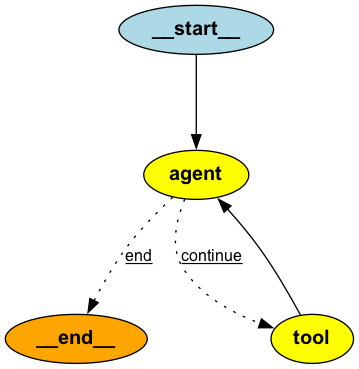

In [6]:
from IPython.display import Image

Image(agent_v1.workflow.get_graph().draw_png())

In [7]:
result = await run_test(agent_v1, clear_intent_1)

INFO:generators.agent_v1:Running agent with message: What are the top Computer on Modules available with high memory and I/O count?
INFO:generators.agent_v1:Starting workflow execution
INFO:generators.agent_v1:Entering agent_node
INFO:generators.agent_v1:Creating prompt template
INFO:generators.agent_v1:Prompt: input_variables=['agent_scratchpad', 'chat_history', 'input'] input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]

Running test for AgentV1
Input: What are the top Computer on Modules available with high memory and I/O count?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:generators.agent_v1:Model response: content='' additional_kwargs={'function_call': {'arguments': '{"query":"Computer on Modules with high memory and I/O count","limit":5}', 'name': 'product_search'}} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 274, 'total_tokens': 301}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_400f27fa1f', 'finish_reason': 'function_call', 'logprobs': None} id='run-e8e4b6a0-dffe-4b4b-80d5-9ff4642e79e3-0' usage_metadata={'input_tokens': 274, 'output_tokens': 27, 'total_tokens': 301}
INFO:generators.agent_v1:Exiting agent_node
INFO:generators.agent_v1:Evaluating whether to continue or end
INFO:generators.agent_v1:Decided to continue
INFO:generators.agent_v1:Entering tool_node
INFO:generators.agent_v1:Executing tool: product_search with arguments: {'query': 'Computer on Modules with high memory and I/O count', 'limit': 5}
INFO:generator

Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Computer on Modules with high memory and I/O count"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:generators.agent_v1:Product search results: [{'form': 'COM Express BASIC TYPE', 'io': '4x USB 3.0, 4x USB 2.0, 4x PCIe Gen3, 4x PCIe Gen2, 2x SATA, 2x GbE', 'manufacturer': 'Kontron', 'memory': 'DDR4, up to 32GB ECC SODIMMs', 'name': 'COMebBD Module', 'processor': 'Intel Xeon Processor Dxx family', 'size': '125mm x 95mm', 'summary': 'The COMebBD Module is a high-performance Computer on Module featuring Intel Xeon processors, supporting up to 32GB DDR4 ECC memory, and offering extensive I/O options including USB, PCIe, SATA, and GbE.'}, {'form': 'COM Express Basic', 'io': 'USB 3.0, USB 2.0, PCIe, SATA, Ethernet, LPC, SPI, I2C, GPIO', 'manufacturer': 'Kontron', 'memory': 'DDR4 SODIMM, up to 128GB, ECC and non-ECC', 'name': 'COMebBD', 'processor': 'Intel Xeon Processor D', 'size': '95mm x 125mm', 'summary': 'High-performance COM Express Basic module with Intel Xeon D processor, supporting up to 16 cores,

Output: ```json
{
    "response_description": "Here are the top Computer on Modules (COMs) available with high memory and I/O count.",
    "response_justification": "These products were selected based on their high memory capacity and extensive I/O options, making them suitable for demanding applications.",
    "products": [
        {
            "name": "COMebBD Module",
            "form": "COM Express BASIC TYPE",
            "processor": "Intel Xeon Processor Dxx family",
            "memory": "DDR4, up to 32GB ECC SODIMMs",
            "io": "4x USB 3.0, 4x USB 2.0, 4x PCIe Gen3, 4x PCIe Gen2, 2x SATA, 2x GbE",
            "manufacturer": "Kontron",
            "size": "125mm x 95mm",
            "summary": "The COMebBD Module is a high-performance Computer on Module featuring Intel Xeon processors, supporting up to 32GB DDR4 ECC memory, and offering extensive I/O options including USB, PCIe, SATA, and GbE."
        },
        {
            "name": "COMebBD",
            "form": "

In [7]:
result = await run_test(agent_v1, "how's the weather today?")

Running test for AgentV1
Input: how's the weather today?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Output: I'm sorry for the confusion, but as a product search assistant, I don't have the ability to provide real-time weather updates. I can help you find products such as weather stations or weather apps.
Stats: {'input_token_count': 4, 'output_token_count': 34}

--------------------------------------------------



## Test Agent V2

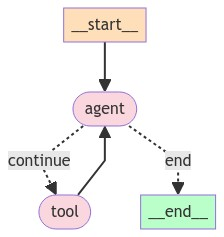

In [4]:
from IPython.display import Image, display

try:
    display(Image(agent_v1.workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
result = await run_test(agent_v1, clear_intent_1)

INFO:generators.agent_v1:Running agent with message: What are the top Computer on Modules available with high memory and I/O count?
INFO:generators.agent_v1:Starting workflow execution
INFO:generators.agent_v1:Entering agent_node
INFO:generators.agent_v1:Creating prompt template
INFO:generators.agent_v1:Prompt: input_variables=['agent_scratchpad', 'chat_history', 'input'] input_types={'chat_history': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]], 'agent_scratchpad': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]

Running test for AgentV1
Input: What are the top Computer on Modules available with high memory and I/O count?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:generators.agent_v1:Model response: content='' additional_kwargs={'function_call': {'arguments': '{"query":"Computer on Modules with high memory and I/O count","limit":5}', 'name': 'product_search'}} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 274, 'total_tokens': 301}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_18cc0f1fa0', 'finish_reason': 'function_call', 'logprobs': None} id='run-f7e3af9d-3cf6-4fe2-86ca-75335e99e7f8-0' usage_metadata={'input_tokens': 274, 'output_tokens': 27, 'total_tokens': 301}
INFO:generators.agent_v1:Exiting agent_node
INFO:generators.agent_v1:Evaluating whether to continue or end
INFO:generators.agent_v1:Decided to continue
INFO:generators.agent_v1:Entering tool_node
INFO:generators.agent_v1:Executing tool: product_search with arguments: {'query': 'Computer on Modules with high memory and I/O count', 'limit': 5}
INFO:generator

Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Computer on Modules with high memory and I/O count"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:generators.agent_v1:Product search results: [{'form': 'COM Express BASIC TYPE', 'io': '4x USB 3.0, 4x USB 2.0, 4x PCIe Gen3, 4x PCIe Gen2, 2x SATA, 2x GbE', 'manufacturer': 'Kontron', 'memory': 'DDR4, up to 32GB ECC SODIMMs', 'name': 'COMebBD Module', 'processor': 'Intel Xeon Processor Dxx family', 'size': '125mm x 95mm', 'summary': 'The COMebBD Module is a high-performance Computer on Module featuring Intel Xeon processors, supporting up to 32GB DDR4 ECC memory, and offering extensive I/O options including USB, PCIe, SATA, and GbE.'}, {'form': 'COM Express Basic', 'io': 'USB 3.0, USB 2.0, PCIe, SATA, Ethernet, LPC, SPI, I2C, GPIO', 'manufacturer': 'Kontron', 'memory': 'DDR4 SODIMM, up to 128GB, ECC and non-ECC', 'name': 'COMebBD', 'processor': 'Intel Xeon Processor D', 'size': '95mm x 125mm', 'summary': 'High-performance COM Express Basic module with Intel Xeon D processor, supporting up to 16 cores,

Output: ```json
{
    "response_description": "Here are the top Computer on Modules (COMs) available with high memory and I/O count.",
    "response_justification": "These products were selected based on their high memory capacity and extensive I/O options, making them suitable for demanding applications.",
    "products": [
        {
            "name": "COMebBD Module",
            "form": "COM Express BASIC TYPE",
            "processor": "Intel Xeon Processor Dxx family",
            "memory": "DDR4, up to 32GB ECC SODIMMs",
            "io": "4x USB 3.0, 4x USB 2.0, 4x PCIe Gen3, 4x PCIe Gen2, 2x SATA, 2x GbE",
            "manufacturer": "Kontron",
            "size": "125mm x 95mm",
            "summary": "The COMebBD Module is a high-performance Computer on Module featuring Intel Xeon processors, supporting up to 32GB DDR4 ECC memory, and offering extensive I/O options including USB, PCIe, SATA, and GbE."
        },
        {
            "name": "COMebBD",
            "form": "

## Test Agent V3

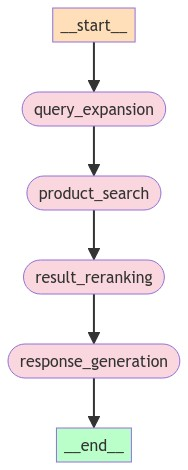

In [4]:
from IPython.display import Image, display

try:
    display(Image(agent_v3.workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
result = await run_test(agent_v3, clear_intent_1)

INFO:generators.agent_v3:Running agent with message: What are the top Computer on Modules available with high memory and I/O count?
INFO:generators.agent_v3:Starting workflow execution
INFO:generators.agent_v3:Entering query_expansion_node
INFO:services.openai_service:Input token count: 90


Running test for AgentV3
Input: What are the top Computer on Modules available with high memory and I/O count?


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.openai_service:Output token count: 94
INFO:generators.agent_v3:Expanded queries: ['What are the top Computer on Modules available with high memory capacity and extensive I/O count?', 'What are the best Computer on Modules with high RAM and numerous I/O ports?', 'Which Computer on Modules have the highest memory and the most I/O interfaces?', 'Top-rated Computer on Modules with large memory and high number of I/O connections', 'Best Computer on Modules featuring high memory and extensive input/output options']
INFO:generators.agent_v3:Entering product_search_node


expand_query response from OpenAI: [    "What are the top Computer on Modules available with high memory capacity and extensive I/O count?",    "What are the best Computer on Modules with high RAM and numerous I/O ports?",    "Which Computer on Modules have the highest memory and the most I/O interfaces?",    "Top-rated Computer on Modules with large memory and high number of I/O connections",    "Best Computer on Modules featuring high memory and extensive input/output options"]
Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["What are the top Computer on Modules available with high memory and I/O count?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["What are the top Computer on Modules available with high memory capacity and extensive I/O count?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["What are the best Computer on Modules with high RAM and numerous I/O ports?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Which Computer on Modules have the highest memory and the most I/O interfaces?"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Top-rated Computer on Modules with large memory and high number of I/O connections"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"


Making request to /v1/graphql
Data: {'query': '{ Get { Product (nearText: { concepts: ["Best Computer on Modules featuring high memory and extensive input/output options"] }, limit: 5) { name, size, form, processor, memory, io, manufacturer, summary } } }'}
Method: POST


INFO:httpx:HTTP Request: POST http://localhost:8080/v1/graphql "HTTP/1.1 200 OK"
INFO:generators.agent_v3:Found 5 unique products
INFO:generators.agent_v3:Entering result_reranking_node
INFO:services.openai_service:Input token count: 365
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.openai_service:Output token count: 126
INFO:root:Reranked names: ['congaTS', 'ET COM Express', 'Computer On Modules', 'Not available', 'TX Computer On Module']
INFO:root:Name to product: {'Computer On Modules': Product(name='Computer On Modules', summary='A COMExpress Basic Module with Intel Core i7/i5/i3/Celeron processors, dual channel DDR3L memory support, and extensive I/O options.', form='COMExpress Basic Module', io='PCIe x16, PCIe x1, SATAIII, USB 2.0, USB 3.0, GbE, VGA, LVDS, DVI, HDMI, DisplayPort', manufacturer='Advantech', memory='Dual Channel DDR3L SODIMM sockets, up to 16GB', processor='Intel Core i7/i5/i3/Celeron', size='125 x 95 mm'),

rerank_products response from OpenAI: [  {    "name": "congaTS",    "relevance_score": 0.95  },  {    "name": "ET COM Express",    "relevance_score": 0.90  },  {    "name": "Computer On Modules",    "relevance_score": 0.85  },  {    "name": "Not available",    "relevance_score": 0.80  },  {    "name": "TX Computer On Module",    "relevance_score": 0.75  }]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:services.openai_service:Output token count: 175
INFO:generators.agent_v3:Generated response: {    "response_description": "Here are the top Computer on Modules available with high memory and I/O count based on your query.",    "response_justification": "The selected products are high-performance COM Express modules featuring the latest Intel processors, extensive I/O options, and robust memory support, which meets the user's requirements for high memory and I/O count.",    "products": [        {            "name": "congaTS"        },        {            "name": "ET COM Express"        },        {            "name": "Computer On Modules"        },        {            "name": "Not available"        },        {            "name": "TX Computer On Module"        }    ],    "additional_info": "If you need more specific details about memory capacity or I/O interfaces, please refine your query or pr

Output: {
  "response_description": "Here are the top Computer on Modules available with high memory and I/O count based on your query.",
  "response_justification": "The selected products are high-performance COM Express modules featuring the latest Intel processors, extensive I/O options, and robust memory support, which meets the user's requirements for high memory and I/O count.",
  "products": [
    {
      "name": "congaTS",
      "summary": "The congaTS is a high-performance COM Express Basic module featuring 8th Generation Intel Core and Intel Xeon processors, supporting dual channel DDR4 memory with ECC, and a variety of I/O interfaces, ideal for data center applications.",
      "form": "COM Express Basic",
      "io": "4x PCI Express Gen 3 lanes, 1x PEG x16 Gen 3, 3x SATA Gen 3, 4x USB 3.1 Gen 2 (10 Gbits), 8x USB 2.0, LPC bus, I2C bus, 2x UART",
      "manufacturer": "congatec AG",
      "memory": "Dual channel DDR4 2666 MT/s, up to 64 GByte, ECC support",
      "processor"